In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pm4py
import scipy
import stormpy
from copy import deepcopy
import numpy as np

In [3]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

# BPIC13 event log

In [4]:
import pandas as pd

event_log = pm4py.read_xes('BPI_Challenge_2013_incidents.xes.gz')
event_log = event_log.sort_values(['case:concept:name','time:timestamp'])
number_of_traces = event_log['case:concept:name'].nunique()
subset_el = event_log[['case:concept:name','concept:name','time:timestamp','org:resource','org:role']]
subset_el['org:role'] = subset_el['org:role'].fillna('nan_1')
subset_el['org:role'] = subset_el['org:role'].apply(lambda x: x.split('_')[0])
subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})
# subset_el['org:role'] = subset_el['org:role'].replace({'C':'nan','D':'nan','E':'nan','V3':'nan','A2':'nan'})
# subset_el['org:resource'] = 'Bob'

df = subset_el

df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df = df.sort_values(by=["case:concept:name", "time:timestamp"]).reset_index(drop=True)
epsilon = 1
# time_unit = 'hours'
# time_factor = 1/3600 # hours
final_states = ['Completed']

from simulation.unfold_events import rename_repeating_events
if epsilon > 1:
    df, final_states = rename_repeating_events(df,epsilon,final_states)
    print(final_states)

/home/vco/.pyenv/versions/ctmc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7554/7554 [00:03<00:00, 2483.26it/s]
/tmp/ipykernel_59639/505782612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_el['org:role'] = subset_el['org:role'].fillna('nan_1')
/tmp/ipykernel_59639/505782612.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [5]:
time_diffs = {}
for case_id, group in df.groupby("case:concept:name"):
    events = group["concept:name"].tolist()
    roles = group["org:role"].tolist()
    times = group["time:timestamp"].tolist()
    for i in range(len(events) - 1):
        pair = (events[i], events[i + 1], roles[i + 1])
        delta_time = (times[i + 1] - times[i]).total_seconds()/3600
        time_diffs.setdefault(pair, []).append(delta_time)
times_dictionary = time_diffs

# Exponential fit and statistical hypothesis tests

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t, entropy, kstest
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance
from scipy import stats
from datetime import datetime, timedelta

from fitter import Fitter, get_common_distributions

def compute_freedman_diaconis_bins(data):
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr / (n ** (1/3))
    return int(np.ceil((np.max(data) - np.min(data)) / bin_width)) if bin_width > 0 else 1

metrics_all = {}

data_mean_transition_role_time = {}
tuples_to_discard = set()

plot = False

sum_of_ssrs = 0
abs_sum_of_ssrs = 0

for i, (pair, deltas) in enumerate(times_dictionary.items()):
    deltas = np.array(deltas)

    mean_time = deltas.mean() # equivalent to 1/expon.fit(deltas, floc=0)
    n = len(set(deltas))
    if n > 3:
        loc, scale = expon.fit(deltas) # equivalent to the Fitter fit
        rate = 1/scale
        k,k2,k3 = pair
        if k not in data_mean_transition_role_time:
            data_mean_transition_role_time[k] = {}
        if k2 not in data_mean_transition_role_time[k]:
            data_mean_transition_role_time[k][k2] = {}
        if k3 not in data_mean_transition_role_time[k][k2]:
            data_mean_transition_role_time[k][k2][k3] = {
                'lambda': rate
            }

        # Histogram
        num_bins = compute_freedman_diaconis_bins(deltas)
        counts, bin_edges = np.histogram(deltas, bins=num_bins, density=True)
        bin_widths = np.diff(bin_edges)
        total = np.sum(counts)
        hist_probs = counts / total

        # Model probabilities over bins
        model_probs = expon.cdf(bin_edges[1:], scale=scale) - expon.cdf(bin_edges[:-1], scale=scale)
        eps = 1e-12
        # kldiv = np.sum(rel_entr(hist_probs, model_probs))
        test_kl_div = entropy(hist_probs + eps, model_probs + eps)
        test2_kl_div = np.sum(kl_div(hist_probs + eps, model_probs + eps))
        ks_test, ks_p_value = kstest(deltas + eps, lambda deltas: expon.cdf(deltas,loc,scale)+eps)
        m = 0.5 * (hist_probs + model_probs)
        js_div = 0.5 * (entropy(hist_probs + eps, m + eps) + entropy(model_probs + eps, m + eps))
        tv_dist = 0.5 * np.sum(np.abs(hist_probs - model_probs))
        w_dist = wasserstein_distance(deltas, expon.rvs(scale=scale, size=len(deltas), random_state=42))

        # Save metrics
        metrics_all[pair] = {
            "rate": scale,
            "kl_divergence": test_kl_div,
            "js_divergence": js_div,
            "total_variation": tv_dist,
            "wasserstein_distance": w_dist,
            "ks_test": ks_test,
            "ks_p_value": ks_p_value,
            "n": n
        }

        # Plot histogram and fits
        if plot:

            # confidence interval
            ci_half_width = t.ppf(0.975, df=n-1) * sem(deltas)
            lower_rate = 1 / (mean_time + ci_half_width)
            upper_rate = 1 / (mean_time - ci_half_width)

            fig, ax = plt.subplots(1,1,figsize=(5, 5), tight_layout=True)
            sns.histplot(deltas, bins=num_bins, stat="density", ax=ax, color="skyblue", label="Empirical")
            x_vals = np.linspace(0, max(deltas) * 1.2, 200)
            ax.plot(x_vals, expon.pdf(x_vals, scale=scale), linestyle="-.", color="purple",
                    label=f"Fitted λ = {rate:.4f}")
            ax.fill_between(x_vals,
                            expon.pdf(x_vals, scale=1 / lower_rate),
                            expon.pdf(x_vals, scale=1 / upper_rate),
                            color="gray", alpha=0.3, label="95% CI band")

            ax.set_title(f"{pair[0]} - {pair[2]} → {pair[1]}")
            ax.set_xlabel(f"Time (hours)")
            ax.set_ylabel("Density")
            q1, q3 = np.percentile(deltas, [25, 75])
            ax.set_xlim(-0.2,max(deltas))
            ax.set_ylim(-0.2,5)
            ax.legend()

            # Text box with metrics
            textstr = 'Metrics:\n'
            textstr += '\n'.join([
                f"KL: {test_kl_div:.4f}",
                f"JS: {js_div:.4f}",
                f"TV: {tv_dist:.4f}",
                f"W: {w_dist:.4f}",
                f"KS: {ks_test:.4f} P: {ks_p_value:.4f}",
                f"N: {n}"
            ])
            ax.text(0.98, 0.55, textstr,
                    transform=ax.transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            plt.tight_layout()
            plt.show()
            filename = f"{pair[0]}-{pair[2]}-{pair[1]}.png"
            filepath = os.path.join("plots", filename)
            plt.savefig(filepath, format="png")
            plt.close()  # Optional but good practice to free memory

    else:
        print(pair)
        #TODO: everything we discard we have to either remove from the DFG frequency or filter the entire event log.
        tuples_to_discard.add(pair)

('Queued', 'Queued', 'C1')
('Queued', 'Completed', 'A2')
('Completed', 'Unmatched', 'E1')
('Unmatched', 'Accepted', 'E1')
('Queued', 'Completed', 'nan')
('Queued', 'Completed', 'V3')


In [7]:
total = len(times_dictionary)
kept = len(times_dictionary) - len(tuples_to_discard)
discarded = len(tuples_to_discard)

print('Kept:', kept)
print('Discarded:', discarded)
kept_percent = (kept / total) * 100
print(f'Kept %: {kept_percent:.2f}%')

Kept: 47
Discarded: 6
Kept %: 88.68%


In [8]:
from scipy.stats import combine_pvalues

total_n = sum(m["n"] for m in metrics_all.values())

# Weighted averages for divergence metrics
kl_weighted = sum(m["kl_divergence"] * m["n"] for m in metrics_all.values()) / total_n
js_weighted = sum(m["js_divergence"] * m["n"] for m in metrics_all.values()) / total_n

# Simple averages for bounded or scale-sensitive distances
tv_average = np.mean([m["total_variation"] for m in metrics_all.values()])
w_average = np.mean([m["wasserstein_distance"] for m in metrics_all.values()])

ks_average = np.mean([m["ks_test"] for m in metrics_all.values()])
stat, ks_combined_p = combine_pvalues([m["ks_p_value"] for m in metrics_all.values()], method='pearson')
# Final aggregate summary
aggregate_metrics = {
    "KL Divergence (weighted)": kl_weighted,
    "JS Divergence (weighted)": js_weighted,
    "Total Variation Distance (mean)": tv_average,
    "Wasserstein Distance (mean)": w_average,
    "KS Test (mean)": ks_average,
    "KS p-value (combined)": ks_combined_p,
    "Total Samples": total_n
}

# Print aggregated metrics
print("\n--- Aggregated Metrics ---")
for key, val in aggregate_metrics.items():
    print(f"{key}: {val:.4f}")

# ---- Display in a New Figure ----
if plot:
    fig_summary, ax_summary = plt.subplots(figsize=(5, 4))
    ax_summary.axis("off")

    summary_text = '\n'.join([
        f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}"
        for k, v in aggregate_metrics.items()
    ])

    ax_summary.text(0.5, 0.5, summary_text,
                    fontsize=11,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

    ax_summary.set_title("Aggregated Fit Metrics")
    plt.tight_layout()
    plt.show()


--- Aggregated Metrics ---
KL Divergence (weighted): 2.3908
JS Divergence (weighted): 0.3697
Total Variation Distance (mean): 0.5852
Wasserstein Distance (mean): 41.8931
KS Test (mean): 0.5787
KS p-value (combined): 0.0000
Total Samples: 34381.0000


# Building the ctmc and running it

In [9]:
subset_el = pm4py.convert_to_event_log(df)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

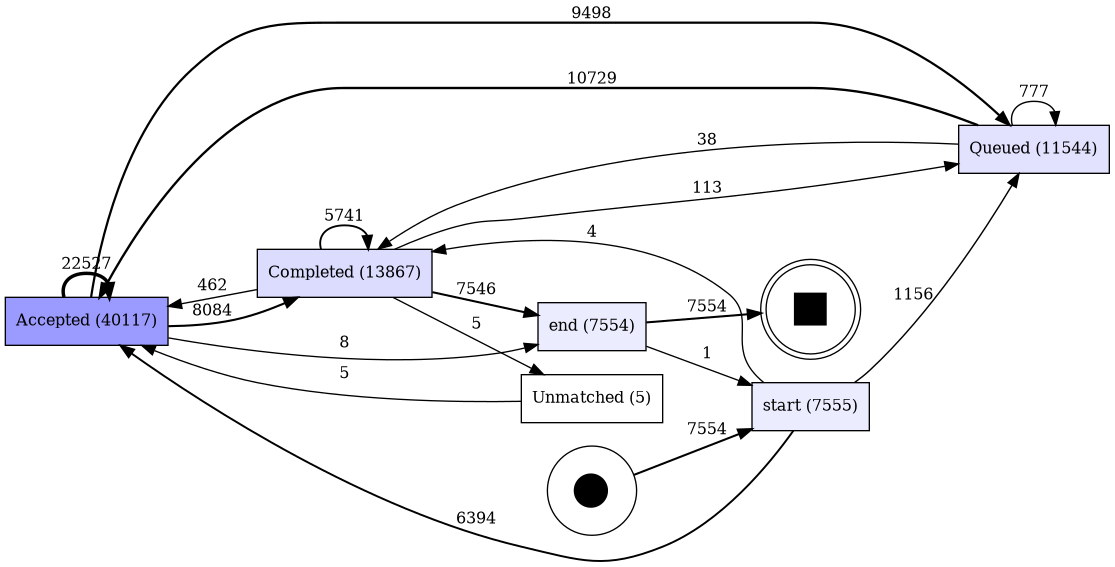

In [10]:
if epsilon<10:
    pm4py.view_dfg(dfg, start_activities, end_activities)

In [11]:
subset_el = pm4py.convert_to_dataframe(subset_el)

In [12]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [13]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [14]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [15]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)

In [16]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [17]:
role_trials = {k:v for k,v in role_resources.items()}

In [18]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

In [19]:
states = set(subset_el['concept:name'].unique()).difference(set(['start','end']))
n = len(states)
i = 0
correspondence = {s:i for s,i in zip(states,range(len(states)))}
#TODO: make sure none of the final states have state = 0 in the prism program
non_final_states = list(states.difference(set(final_states)))
for s in final_states:
    if correspondence[s] == 0:
        correspondence[s] = correspondence[non_final_states[0]]
        correspondence[non_final_states[0]] = 0
sorted(correspondence)

['Accepted', 'Completed', 'Queued', 'Unmatched']

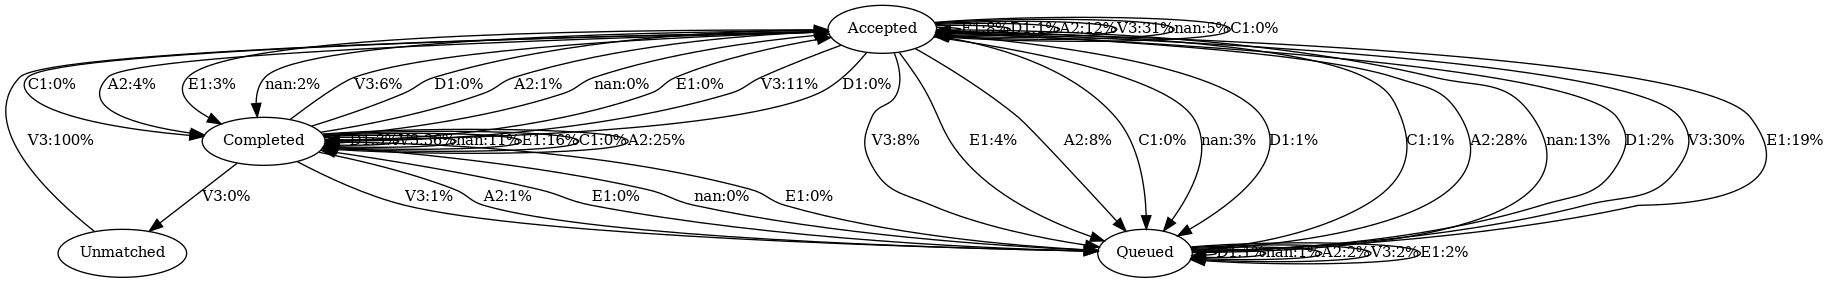

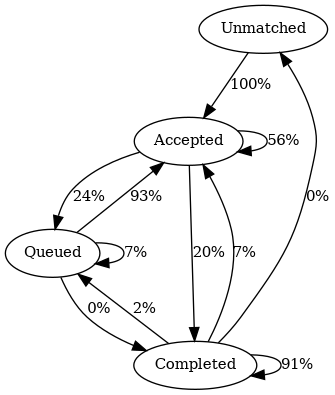

In [20]:
if epsilon<10:
    view_resource_markov_chain(data_transition_role_prob)
view_non_resource_markov_chain(res)

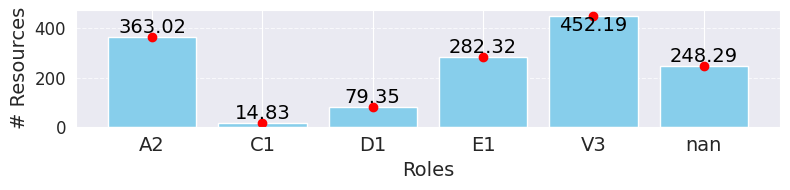

In [21]:
def plot_resources(organizational_roles,save=False):
    # Plot the histogram (bar chart)
    fig, ax = plt.subplots(figsize=(8, 2))
    roles = list(organizational_roles.keys())
    values = list(organizational_roles.values())

    # Bar chart
    bars = ax.bar(roles, values, color='skyblue')

    # Define a top threshold (e.g., 95% of max value for the y-axis)
    y_max = max(values) * 1.05  # Increase y-limit for spacing
    ax.set_ylim(0, y_max)
    threshold = y_max * 0.9

    # Add point and value label smartly
    for bar, value in zip(bars, values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.plot(x, y, 'o', color='red')  # Red dot

        # Decide label position
        if y > threshold:
            va = 'top'
            y_offset = -0.08
        else:
            va = 'bottom'
            y_offset = 0.08

        ax.text(x, y + y_offset, f"{value:.2f}", ha='center', va=va, fontsize=14, color='black')

    # Labels and grid with increased font size
    ax.set_xlabel('Roles', fontsize=14)
    ax.set_ylabel('# Resources', fontsize=14)
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis (role labels) font size
    ax.tick_params(axis='y', labelsize=12)  # (Optional) Increase y-axis tick label size
    # ax.set_title('BPIC 13 Resource allocation', fontsize=16)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    # Save the plot
    if save:
        plot_filename = "plots/bpic13roles.png"
        plt.savefig(plot_filename)
    plt.show()
    plt.close()

plot_resources(role_resources)

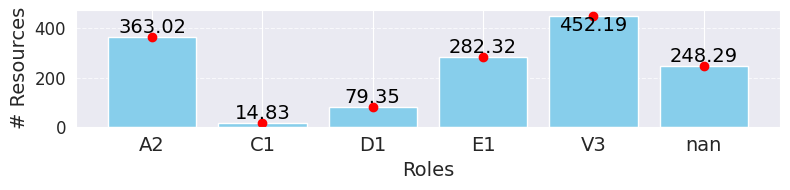

In [22]:
#TODO: Play with the role trials, by for example uncommenting the line below to make A2 = 200
# role_trials['A2'] = 200
plot_resources(role_trials)
for k, v in role_trials.items():
    if v<=0:
        raise ValueError('Cannot have 0 or negative number of resources !')

In [23]:
from simulation.ctmc_frequency import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc-bpic13.sm',
                            show_print=False)
prism_program = stormpy.parse_prism_program('ctmc-bpic13.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)

def get_result(model, prism_program):
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]
    formula_str = f'Tmin=? [F {labels}]'
    print(f"[!] Formula: {formula_str}")
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    print(f"Duration: {timedelta(hours=result)}")
    return result

result = get_result(model,prism_program)

[!] Formula: Tmin=? [F "q_terminal_Completed"]
Duration: 11 days, 11:12:59.561601


# Analysis between ground truth, result and metrics

# Resource Regression Analysis

In [24]:
import random

durations = []
# x = list(range(1,50))
samples = 1000
for i in range(samples):
    regression_role_trials = {}
    for k,v in role_trials.items():
        # random_resource_number = abs(random.gauss(v,v/2))
        random_resource_number = abs(random.uniform(v/2,v*2))
        regression_role_trials[k] = random_resource_number
    probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            regression_role_trials,
                            'ctmc-bpic13-temp.sm')
    prism_program = stormpy.parse_prism_program('ctmc-bpic13-temp.sm', prism_compat=True, simplify=True)
    model = stormpy.build_model(prism_program)
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]

    formula_str = f'Tmin=? [F {labels}]'
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    durations.append({**regression_role_trials, "duration": result})
    # print(f'{i}/{samples}')

In [25]:
durations_df = pd.DataFrame(durations)
durations_df

,A2,C1,D1,E1,V3,nan,duration
0,525.312040,12.068429,94.991377,416.465803,409.568871,313.832226,248.140664
1,246.079275,12.187763,137.374719,547.269511,803.262106,304.302633,165.189604
2,384.052530,28.003472,86.926133,533.891936,433.565030,242.715874,234.070632
3,310.560350,9.727173,155.523165,473.047475,308.853842,458.878977,284.975613
4,626.457755,29.442632,66.462800,455.909042,860.848231,139.701997,156.182431
...,...,...,...,...,...,...,...
995,473.993544,17.288920,136.940607,286.071019,756.404140,297.442222,190.123500
996,550.725563,16.221327,153.031933,500.155454,444.245406,337.924134,223.156139
997,624.826529,20.626738,85.702779,366.648675,657.377905,441.200393,188.431716
998,466.135766,22.804486,79.840594,504.374033,227.656887,248.778954,312.803331


In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example: Load your DataFrame
# df = pd.read_csv("your_data.csv")

def run_linear_regression(df, target_column, fit_intercept=True):
    # Split into X (features) and y (target)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Fit model
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X, y)

    # Print model coefficients
    intercept = model.intercept_
    coef = model.coef_
    print("Intercept:", intercept if fit_intercept else "Not used")
    print("Coefficients:")
    for col, weight in zip(X.columns, coef):
        print(f"{col}: {weight:.4f}")

    return model, X.columns, coef

def rank_features_by_importance(X, coef):
    importance_df = pd.DataFrame({
        'Feature': X,
        'Coefficient': coef,
        'Importance (abs)': abs(coef)
    })
    return importance_df.sort_values(by='Importance (abs)', ascending=False)

# Run regression
model, features, coefs = run_linear_regression(durations_df, 'duration', fit_intercept=True)

# Rank features
ranking = rank_features_by_importance(features, coefs)
print("\nFeature Ranking:\n", ranking)

Intercept: 483.8696963794008
Coefficients:
A2: -0.0714
C1: 0.1125
D1: -0.0066
E1: -0.1668
V3: -0.2655
nan: -0.0270

Feature Ranking:
   Feature  Coefficient  Importance (abs)
4      V3    -0.265523          0.265523
3      E1    -0.166774          0.166774
1      C1     0.112516          0.112516
0      A2    -0.071436          0.071436
5     nan    -0.026953          0.026953
2      D1    -0.006612          0.006612


# pm4py values

kalenkova values range between 12d1h to 8d22h in the optimized analysis

In [27]:
print(pm4py.get_cycle_time(subset_el))
mean, median, margin_of_error = sim_util.get_pm4py_reference_times(subset_el)
print('median',timedelta(seconds=median))
print('mean',timedelta(seconds=mean))
print('+- error:',timedelta(seconds=margin_of_error))

0.0
median 7 days, 13:10:44.500000
mean 12 days, 1:56:08.296532
+- error: 15:27:58.854683
